In [1]:
!unzip /content/archive.zip

Archive:  /content/archive.zip
  inflating: dataset/cataract/0_left.jpg  
  inflating: dataset/cataract/103_left.jpg  
  inflating: dataset/cataract/1062_right.jpg  
  inflating: dataset/cataract/1083_left.jpg  
  inflating: dataset/cataract/1084_right.jpg  
  inflating: dataset/cataract/1102_left.jpg  
  inflating: dataset/cataract/1102_right.jpg  
  inflating: dataset/cataract/1115_left.jpg  
  inflating: dataset/cataract/1126_right.jpg  
  inflating: dataset/cataract/112_right.jpg  
  inflating: dataset/cataract/1144_left.jpg  
  inflating: dataset/cataract/1144_right.jpg  
  inflating: dataset/cataract/1164_left.jpg  
  inflating: dataset/cataract/1167_right.jpg  
  inflating: dataset/cataract/119_left.jpg  
  inflating: dataset/cataract/1285_left.jpg  
  inflating: dataset/cataract/1415_left.jpg  
  inflating: dataset/cataract/1415_right.jpg  
  inflating: dataset/cataract/1435_left.jpg  
  inflating: dataset/cataract/1444_left.jpg  
  inflating: dataset/cataract/1452_left.jpg  
 

100%|██████████| 1098/1098 [00:02<00:00, 510.24it/s]


Epoch 1/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 21s 212ms/step - accuracy: 0.6196 - loss: 1.4552 - val_accuracy: 0.8412 - val_loss: 0.4258
Epoch 2/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 16s 181ms/step - accuracy: 0.7892 - loss: 0.5213 - val_accuracy: 0.8261 - val_loss: 0.4428
Epoch 3/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 20s 179ms/step - accuracy: 0.8374 - loss: 0.4305 - val_accuracy: 0.8506 - val_loss: 0.3840
Epoch 4/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 20s 178ms/step - accuracy: 0.8474 - loss: 0.3768 - val_accuracy: 0.8463 - val_loss: 0.3832
Epoch 5/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 16s 179ms/step - accuracy: 0.8529 - loss: 0.3810 - val_accuracy: 0.8412 - val_loss: 0.4015
Epoch 6/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 26s 237ms/step - accuracy: 0.8719 - loss: 0.3089 - val_accuracy: 0.8599 - val_loss: 0.3599
Epoch 7/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 16s 179ms/step - accuracy: 0.8788 - loss: 0.3269 - val_accuracy: 0.8484 - val_loss: 0.3920
Epoch 8/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 26s 237ms/step - accuracy: 0.8931 - loss: 0.2963 - val_accu

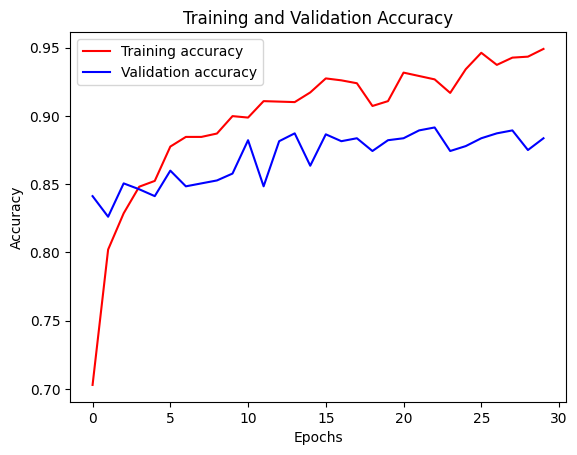

44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step
Classification Report:
                       precision    recall  f1-score   support

            cataract       0.89      0.94      0.91       352
            glaucoma       0.79      0.80      0.79       340
              normal       0.86      0.82      0.84       350
diabetic_retinopathy       0.99      0.97      0.98       350

            accuracy                           0.88      1392
           macro avg       0.88      0.88      0.88      1392
        weighted avg       0.88      0.88      0.88      1392

Confusion Matrix:
 [[332  12   8   0]
 [ 32 271  37   0]
 [  9  51 288   2]
 [  1   9   1 339]]
Overall Accuracy: 0.8836
Weighted Precision: 0.8842
Weighted Recall: 0.8836
Weighted F1 Score: 0.8835
Accuracy for cataract: 0.9432
Accuracy for glaucoma: 0.7971
Accuracy for normal: 0.8229
Accuracy for diabetic_retinopathy: 0.9686


In [3]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt
import os, cv2
from tqdm import tqdm

# Load the VGG16 model, pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Set the dataset path
dataset_path = '/content/dataset'
classes = ['cataract', 'glaucoma', 'normal', 'diabetic_retinopathy']

# Prepare the dataset
X = []
y = []

for i, class_name in enumerate(classes):
    class_path = os.path.join(dataset_path, class_name)
    for img_name in tqdm(os.listdir(class_path)):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (224, 224))
            X.append(img)
            y.append(i)

X = np.array(X)
y = np.array(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# One-hot encode the labels
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

# Freeze the base layers
base_model.trainable = False

# Add custom layers
def add_custom_layers(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dropout(0.5)(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    top_model = Dense(num_classes, activation='softmax')(top_model)
    return top_model

num_classes = len(classes)
custom_model_output = add_custom_layers(base_model, num_classes)

# Create the final model
model = Model(inputs=base_model.input, outputs=custom_model_output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), verbose=1)

# Plot accuracy
if 'accuracy' in history.history and 'val_accuracy' in history.history:
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
else:
    print("Accuracy data not found in history.")

# Model evaluation
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification report and metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print("Classification Report:\n", classification_report(y_true_classes, y_pred_classes, target_names=classes))
print("Confusion Matrix:\n", confusion_matrix(y_true_classes, y_pred_classes))
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1 Score: {f1:.4f}")

# Accuracy per class
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
for i, class_name in enumerate(classes):
    print(f"Accuracy for {class_name}: {class_accuracy[i]:.4f}")